In [2]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

#import IPython.display as disp
from timm.data import Mixup
from timm.data.random_erasing import RandomErasing as RandomErasingTimm
from timm.loss import SoftTargetCrossEntropy
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d

In [3]:
%env WANDB_SILENT=true
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [17]:
VERSION  = "NB_EXP_016"
EXP_NAME = f"{VERSION}_swin_base_patch4_window7"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); os.makedirs(MODEL_FOLDER, exist_ok=True)

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL  = "swin_base_patch4_window7_224_in22k"

NFOLDS = 5
BS = 32
SZ = 224

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 1.0
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [18]:
all_df = pd.read_csv(CSV_PATH)

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [19]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [20]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [21]:
def get_dls(fold:int, bs:int, *args, **kwargs):
    
    item_tfms = [ToTensor, AlbumentationsTransform(TRAIN_AUG,VALID_AUG)]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

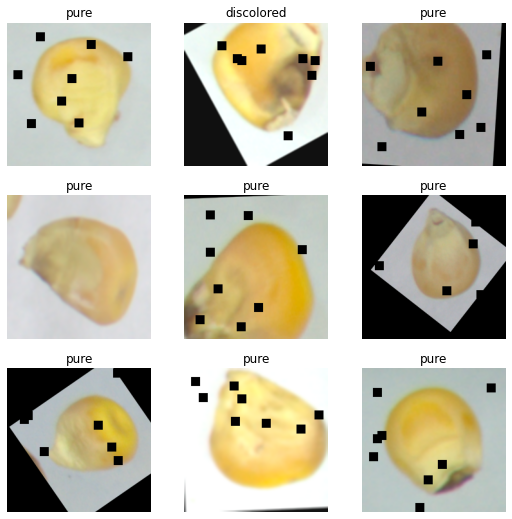

In [22]:
dls = get_dls(0, BS)
dls.show_batch()

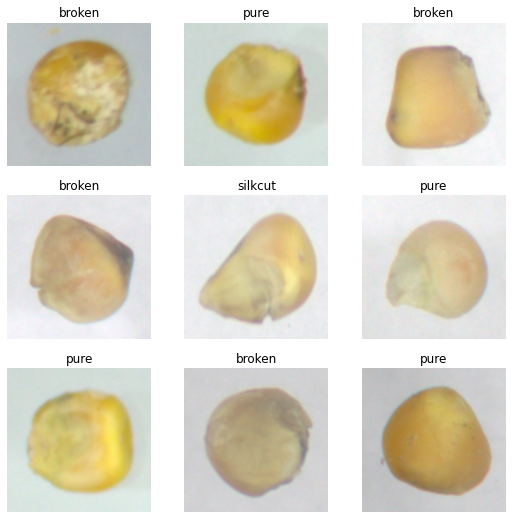

In [23]:
dls.valid.show_batch()

In [24]:
def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f'model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f'fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=pretrained,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy]).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

 model:swin_base_patch4_window7_224_in22k; pretrained:True
 fold:0; sz:224; bs:32


SuggestedLRs(valley=0.0006918309954926372, slide=0.0010000000474974513)
CPU: 1569/134/3238 MB | GPU: 998/3460/2501 MB | Time 0:00:14.430 | (Consumed/Peaked/Used Total)


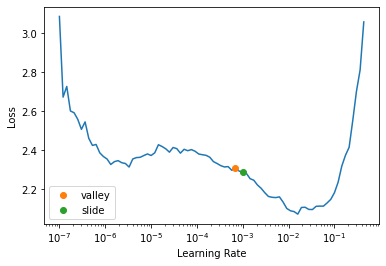

In [25]:
set_seed(42); set_fast_norm()

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [27]:
n_epo = 15; base_lr = 0.001;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup_ft"

In [29]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f'epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   MixUp(0.4),
                   WandbCallback(log_preds=None)]
            
            learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
 model:swin_base_patch4_window7_224_in22k; pretrained:True
 fold:0; sz:224; bs:32
 epochs:15; base_lr:0.001


epoch,train_loss,valid_loss,accuracy,time
0,1.383590,0.928114,0.653403,00:49


Better model found at epoch 0 with accuracy value: 0.6534031629562378.


epoch,train_loss,valid_loss,accuracy,time
0,1.192205,0.746608,0.699476,01:07
1,1.091741,0.688142,0.717627,01:08
2,1.005195,0.648891,0.735777,01:08
3,0.911465,0.606062,0.751134,01:08
4,0.865800,0.598345,0.765096,01:08
5,0.829837,0.569495,0.773822,01:08
6,0.801872,0.551338,0.782548,01:08
7,0.763131,0.541421,0.786387,01:08
8,0.783671,0.524226,0.793019,01:08
9,0.756061,0.525154,0.788133,01:08


Better model found at epoch 0 with accuracy value: 0.699476420879364.
Better model found at epoch 1 with accuracy value: 0.7176265120506287.
Better model found at epoch 2 with accuracy value: 0.7357766032218933.
Better model found at epoch 3 with accuracy value: 0.7511343955993652.
Better model found at epoch 4 with accuracy value: 0.7650960087776184.
Better model found at epoch 5 with accuracy value: 0.773822009563446.
Better model found at epoch 6 with accuracy value: 0.7825480103492737.
Better model found at epoch 7 with accuracy value: 0.7863874435424805.
Better model found at epoch 8 with accuracy value: 0.79301917552948.
Better model found at epoch 10 with accuracy value: 0.7937172651290894.
Better model found at epoch 11 with accuracy value: 0.7944153547286987.
Better model found at epoch 12 with accuracy value: 0.7951134443283081.
Better model found at epoch 13 with accuracy value: 0.7979057431221008.
Better model found at epoch 14 with accuracy value: 0.8006981015205383.
CPU: 


****************************************************************************************************
Training fold 1
****************************************************************************************************
 model:swin_base_patch4_window7_224_in22k; pretrained:True
 fold:1; sz:224; bs:32
 epochs:15; base_lr:0.001


epoch,train_loss,valid_loss,accuracy,time
0,1.410553,0.844096,0.669459,00:50


Better model found at epoch 0 with accuracy value: 0.6694589853286743.


epoch,train_loss,valid_loss,accuracy,time
0,1.188218,0.709838,0.708901,01:08
1,1.065019,0.665057,0.724258,01:08
2,0.995728,0.638989,0.731239,01:08
3,0.911442,0.612503,0.754625,01:08
4,0.860212,0.582726,0.762653,01:08
5,0.822148,0.558155,0.771379,01:08
6,0.825175,0.535314,0.782548,01:08
7,0.775977,0.529785,0.784991,01:08
8,0.786164,0.542785,0.781501,01:08
9,0.789262,0.527961,0.789529,01:08


Better model found at epoch 0 with accuracy value: 0.708900511264801.
Better model found at epoch 1 with accuracy value: 0.724258303642273.
Better model found at epoch 2 with accuracy value: 0.7312390804290771.
Better model found at epoch 3 with accuracy value: 0.7546247839927673.
Better model found at epoch 4 with accuracy value: 0.7626526951789856.
Better model found at epoch 5 with accuracy value: 0.7713786959648132.
Better model found at epoch 6 with accuracy value: 0.7825480103492737.
Better model found at epoch 7 with accuracy value: 0.7849912643432617.
Better model found at epoch 9 with accuracy value: 0.7895287871360779.
Better model found at epoch 10 with accuracy value: 0.7954624891281128.
CPU: 1/180/4021 MB | GPU: 256/6000/4041 MB | Time 0:18:21.769 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
 model:swin_base_patch4_window7_224_in22k; pretrained:True
 fold:2; sz:224; bs:32
 epochs:15; base_lr:0.001


epoch,train_loss,valid_loss,accuracy,time
0,1.353066,0.907292,0.662360,00:50


Better model found at epoch 0 with accuracy value: 0.6623603105545044.


epoch,train_loss,valid_loss,accuracy,time
0,1.154681,0.714475,0.713338,01:08
1,1.071128,0.677818,0.725908,01:08
2,0.984441,0.676821,0.723813,01:08
3,0.919336,0.613606,0.749302,01:08
4,0.894552,0.594759,0.762919,01:08
5,0.829024,0.561001,0.775489,01:08
6,0.805377,0.549840,0.781075,01:08
7,0.784435,0.537798,0.789106,01:08
8,0.767905,0.533935,0.783520,01:08
9,0.770838,0.513349,0.796788,01:08


Better model found at epoch 0 with accuracy value: 0.7133380174636841.
Better model found at epoch 1 with accuracy value: 0.7259078025817871.
Better model found at epoch 3 with accuracy value: 0.7493016719818115.
Better model found at epoch 4 with accuracy value: 0.762919008731842.
Better model found at epoch 5 with accuracy value: 0.7754888534545898.
Better model found at epoch 6 with accuracy value: 0.7810754179954529.
Better model found at epoch 7 with accuracy value: 0.7891061305999756.
Better model found at epoch 9 with accuracy value: 0.7967877388000488.
Better model found at epoch 11 with accuracy value: 0.7992318272590637.
Better model found at epoch 12 with accuracy value: 0.8002793192863464.
Better model found at epoch 13 with accuracy value: 0.8009776473045349.
Better model found at epoch 14 with accuracy value: 0.8034217953681946.
CPU: -7/129/4013 MB | GPU: 118/5874/4159 MB | Time 0:18:24.351 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
De


****************************************************************************************************
Training fold 3
****************************************************************************************************
 model:swin_base_patch4_window7_224_in22k; pretrained:True
 fold:3; sz:224; bs:32
 epochs:15; base_lr:0.001


epoch,train_loss,valid_loss,accuracy,time
0,1.396890,0.858461,0.676676,00:50


Better model found at epoch 0 with accuracy value: 0.6766759753227234.


epoch,train_loss,valid_loss,accuracy,time
0,1.153111,0.716581,0.706355,01:08
1,1.072534,0.710000,0.710894,01:08
2,0.978017,0.633036,0.750349,01:08
3,0.916236,0.600700,0.751746,01:08
4,0.886747,0.560414,0.776187,01:08
5,0.844053,0.541993,0.779330,01:08
6,0.817958,0.527542,0.795042,01:08
7,0.799989,0.514773,0.791899,01:08
8,0.784036,0.499925,0.801327,01:08
9,0.781448,0.506461,0.796788,01:08


Better model found at epoch 0 with accuracy value: 0.7063547372817993.
Better model found at epoch 1 with accuracy value: 0.7108938694000244.
Better model found at epoch 2 with accuracy value: 0.7503491640090942.
Better model found at epoch 3 with accuracy value: 0.7517458200454712.
Better model found at epoch 4 with accuracy value: 0.7761871218681335.
Better model found at epoch 5 with accuracy value: 0.7793295979499817.
Better model found at epoch 6 with accuracy value: 0.7950419187545776.
Better model found at epoch 8 with accuracy value: 0.8013268113136292.
Better model found at epoch 10 with accuracy value: 0.8016759753227234.
Better model found at epoch 11 with accuracy value: 0.8037709593772888.
Better model found at epoch 13 with accuracy value: 0.8048184514045715.
CPU: 0/135/4012 MB | GPU: 110/5780/4269 MB | Time 0:18:23.819 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 4
****************************************************************************************************
 model:swin_base_patch4_window7_224_in22k; pretrained:True
 fold:4; sz:224; bs:32
 epochs:15; base_lr:0.001


epoch,train_loss,valid_loss,accuracy,time
0,1.405204,0.939541,0.648394,00:50


Better model found at epoch 0 with accuracy value: 0.6483938694000244.


epoch,train_loss,valid_loss,accuracy,time
0,1.190976,0.687582,0.724162,01:08
1,1.062105,0.673125,0.727654,01:08
2,0.994470,0.614133,0.747556,01:08
3,0.916899,0.584875,0.761522,01:08
4,0.881985,0.555930,0.777933,01:08
5,0.843763,0.536906,0.787709,01:08
6,0.817549,0.526099,0.791201,01:08
7,0.785152,0.512145,0.795391,01:08
8,0.785362,0.492192,0.804120,01:08
9,0.768909,0.490139,0.800628,01:08


Better model found at epoch 0 with accuracy value: 0.7241619825363159.
Better model found at epoch 1 with accuracy value: 0.7276536226272583.
Better model found at epoch 2 with accuracy value: 0.7475558519363403.
Better model found at epoch 3 with accuracy value: 0.7615223526954651.
Better model found at epoch 4 with accuracy value: 0.7779329419136047.
Better model found at epoch 5 with accuracy value: 0.7877094745635986.
Better model found at epoch 6 with accuracy value: 0.791201114654541.
Better model found at epoch 7 with accuracy value: 0.7953910827636719.
Better model found at epoch 8 with accuracy value: 0.8041201233863831.
Better model found at epoch 10 with accuracy value: 0.80551677942276.
Better model found at epoch 12 with accuracy value: 0.8093575239181519.
Better model found at epoch 13 with accuracy value: 0.8100558519363403.
CPU: 0/136/4013 MB | GPU: 432/5386/4701 MB | Time 0:18:26.618 | (Consumed/Peaked/Used Total)


In [30]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

 model:swin_base_patch4_window7_224_in22k; pretrained:False
 fold:0; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_016_swin_base_patch4_window7_224_bs32_epo15_mixup_ft_CV_00' (00)


* Accuracy : 0.8038394451141357

 model:swin_base_patch4_window7_224_in22k; pretrained:False
 fold:1; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_016_swin_base_patch4_window7_224_bs32_epo15_mixup_ft_CV_01' (01)


* Accuracy : 0.7954624891281128

 model:swin_base_patch4_window7_224_in22k; pretrained:False
 fold:2; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_016_swin_base_patch4_window7_224_bs32_epo15_mixup_ft_CV_02' (02)


* Accuracy : 0.8104050159454346

 model:swin_base_patch4_window7_224_in22k; pretrained:False
 fold:3; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_016_swin_base_patch4_window7_224_bs32_epo15_mixup_ft_CV_03' (03)


* Accuracy : 0.811103343963623

 model:swin_base_patch4_window7_224_in22k; pretrained:False
 fold:4; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_016_swin_base_patch4_window7_224_bs32_epo15_mixup_ft_CV_04' (04)


* Accuracy : 0.8086591958999634

CPU: 0/91/4013 MB | GPU: -1976/1406/2725 MB | Time 0:01:57.574 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80384, 0.79546, 0.81041, 0.8111, 0.80866]
Avg: 0.80589
Std: 0.00580
